# EPL Machine Learning Task

Betfair data science challenges.


In [118]:
import datetime
import requests
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', 100)
sns.set(style='darkgrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.set_context('paper') # paper or talk 

import sklearn
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score

import matplotlib.pyplot as plt
%matplotlib inline

from bs4 import BeautifulSoup

# Data acquisition and exploration 

Get data from football-data.co.uk using BeautifulSoup.

The data is in separate CSVs based on the season. That means we would need to manually download 20 different files if we wanted the past 20 seasons. Instead, lets use BeautifulSoup and create a function which downloads the files  and appends them into a CSV.

In [4]:
def grab_epl_data():
    # Connect to football-data.co.uk
    res = requests.get("http://www.football-data.co.uk/englandm.php")

    # Create a BeautifulSoup object
    soup = BeautifulSoup(res.content, 'lxml')

    # Find the tables with the links to the data in them.
    table = soup.find_all('table', {'align': 'center', 'cellspacing': '0', 'width': '800'})[1]
    body = table.find_all('td', {'valign': 'top'})[1]

    # Grab the urls for the csv files
    links = [link.get('href') for link in body.find_all('a')]
    links_text = [link_text.text for link_text in body.find_all('a')]

    data_urls = []

    # Create a list of links
    prefix = 'http://www.football-data.co.uk/'
    for i, text in enumerate(links_text):
        if text == 'Premier League':
            data_urls.append(prefix + links[i])

    # Get rid of last 11 uls as these don't include match stats and odds, and we
    # only want from 2005 onwards
    data_urls = data_urls[:-12]

    df = pd.DataFrame()

    # Iterate over the urls
    for url in data_urls:
        # Get the season and make it a column
        season = url.split('/')[4]

        print(f"Getting data for season {season}")

        # Read the data from the url into a DataFrame
        temp_df = pd.read_csv(url)
        temp_df['season'] = season

        # Create helpful columns like Day, Month, Year, Date etc. so that our data is clean
        temp_df = (temp_df.dropna(axis='columns', thresh=temp_df.shape[0]-30)
                          .assign(Day=lambda df: df.Date.str.split('/').str[0],
                                  Month=lambda df: df.Date.str.split('/').str[1],
                                  Year=lambda df: df.Date.str.split('/').str[2])
                          .assign(Date=lambda df: df.Month + '/' + df.Day + '/' + df.Year)
                          .assign(Date=lambda df: pd.to_datetime(df.Date))
                          .dropna())

        # Append the temp_df to the main df
        df = df.append(temp_df, sort=True)

    # Drop all NAs
    df = df.dropna(axis=1).dropna().sort_values(by='Date')
    print("Finished grabbing data.")

    return df

In [9]:
df = grab_epl_data()
# df.to_csv("data/epl_data.csv", index=False)

Getting data for season 2021
Getting data for season 1920
Getting data for season 1819
Getting data for season 1718
Getting data for season 1617
Getting data for season 1516
Getting data for season 1415
Getting data for season 1314
Getting data for season 1213
Getting data for season 1112
Getting data for season 1011
Getting data for season 0910
Getting data for season 0809
Getting data for season 0708
Getting data for season 0607
Getting data for season 0506
Finished grabbing data.


# Data Exploration

Now we have the dataframe we can examine it. Lets have a look at the top and tail of the data. 

In [10]:
df.head()

,AC,AF,AR,AS,AST,AY,AwayTeam,B365A,B365D,B365H,BWA,BWD,BWH,Date,Day,Div,FTAG,FTHG,FTR,HC,HF,HR,HS,HST,HTAG,HTHG,HTR,HY,HomeTeam,IWA,IWD,IWH,Month,Referee,VCA,VCD,VCH,Year,season
7,6.0,14.0,1.0,11.0,5.0,1.0,Blackburn,2.75,3.20,2.50,2.90,3.30,2.20,2005-08-13,13,E0,1.0,3.0,H,2.0,11.0,0.0,13.0,5.0,1.0,0.0,A,0.0,West Ham,2.7,3.0,2.3,08,A Wiley,2.75,3.25,2.40,05,0506
0,8.0,16.0,0.0,13.0,6.0,2.0,Bolton,3.00,3.25,2.30,3.15,3.25,2.10,2005-08-13,13,E0,2.0,2.0,D,7.0,14.0,0.0,3.0,2.0,2.0,2.0,D,0.0,Aston Villa,3.1,3.0,2.1,08,M Riley,3.10,3.25,2.20,05,0506
1,6.0,14.0,0.0,12.0,5.0,1.0,Man United,1.72,3.40,5.00,1.75,3.35,4.35,2005-08-13,13,E0,2.0,0.0,A,8.0,15.0,0.0,10.0,5.0,1.0,0.0,A,3.0,Everton,1.8,3.1,3.8,08,G Poll,1.80,3.30,4.50,05,0506
2,6.0,13.0,0.0,7.0,4.0,2.0,Birmingham,2.87,3.25,2.37,2.80,3.20,2.30,2005-08-13,13,E0,0.0,0.0,D,6.0,12.0,0.0,15.0,7.0,0.0,0.0,D,1.0,Fulham,2.9,3.0,2.2,08,R Styles,2.80,3.25,2.35,05,0506
3,6.0,11.0,0.0,13.0,3.0,3.0,West Brom,5.00,3.40,1.72,4.80,3.45,1.65,2005-08-13,13,E0,0.0,0.0,D,3.0,13.0,0.0,15.0,8.0,0.0,0.0,D,2.0,Man City,4.2,3.2,1.7,08,C Foy,5.00,3.25,1.75,05,0506


In [11]:
df.tail()

,AC,AF,AR,AS,AST,AY,AwayTeam,B365A,B365D,B365H,BWA,BWD,BWH,Date,Day,Div,FTAG,FTHG,FTR,HC,HF,HR,HS,HST,HTAG,HTHG,HTR,HY,HomeTeam,IWA,IWD,IWH,Month,Referee,VCA,VCD,VCH,Year,season
220,0.0,12.0,0.0,4.0,1.0,2.0,West Brom,7.00,4.5,1.45,7.00,4.33,1.48,2021-02-07,07,E0,0.0,2.0,H,8.0,16.0,0.0,13.0,6.0,0.0,0.0,D,1.0,Tottenham,7.00,4.6,1.45,02,S Attwell,7.50,4.50,1.44,2021,2021
222,1.0,8.0,0.0,8.0,5.0,1.0,Man City,2.05,3.6,3.40,2.05,3.70,3.40,2021-02-07,07,E0,4.0,1.0,A,6.0,13.0,0.0,8.0,3.0,0.0,0.0,D,2.0,Liverpool,2.20,3.4,3.40,02,M Oliver,2.10,3.60,3.40,2021,2021
223,8.0,8.0,0.0,9.0,3.0,0.0,Chelsea,1.45,4.5,7.00,1.50,4.10,7.25,2021-02-07,07,E0,2.0,1.0,A,1.0,8.0,0.0,8.0,3.0,1.0,0.0,A,1.0,Sheffield United,1.47,4.4,7.00,02,K Friend,1.45,4.33,7.50,2021,2021
221,2.0,15.0,0.0,13.0,3.0,3.0,Leicester,2.10,3.4,3.50,2.15,3.40,3.40,2021-02-07,07,E0,0.0,0.0,D,8.0,11.0,0.0,13.0,1.0,0.0,0.0,D,1.0,Wolves,2.15,3.3,3.50,02,M Atkinson,2.15,3.25,3.60,2021,2021
224,3.0,8.0,0.0,8.0,3.0,2.0,Crystal Palace,4.20,3.8,1.80,4.10,3.80,1.85,2021-02-08,08,E0,0.0,2.0,H,5.0,7.0,0.0,17.0,7.0,0.0,1.0,H,0.0,Leeds,3.95,3.8,1.85,02,A Marriner,4.10,3.80,1.85,2021,2021


In [14]:
# Create Home Win, Draw and Away Win columns
df = df.assign(HomeWin=lambda df: df.apply(lambda row: 1 if row.FTHG > row.FTAG else 0, axis='columns'),
              Draw=lambda df: df.apply(lambda row: 1 if row.FTHG == row.FTAG else 0, axis='columns'),
              AwayWin=lambda df: df.apply(lambda row: 1 if row.FTHG < row.FTAG else 0, axis='columns'))

In [18]:
# df.drop(['homeWin', 'draw', 'awayWin'], axis=1)

,AC,AF,AR,AS,AST,AY,AwayTeam,B365A,B365D,B365H,BWA,BWD,BWH,Date,Day,Div,FTAG,FTHG,FTR,HC,HF,HR,HS,HST,HTAG,HTHG,HTR,HY,HomeTeam,IWA,IWD,IWH,Month,Referee,VCA,VCD,VCH,Year,season,HomeWin,Draw,AwayWin
7,6.0,14.0,1.0,11.0,5.0,1.0,Blackburn,2.75,3.20,2.50,2.90,3.30,2.20,2005-08-13,13,E0,1.0,3.0,H,2.0,11.0,0.0,13.0,5.0,1.0,0.0,A,0.0,West Ham,2.70,3.0,2.30,08,A Wiley,2.75,3.25,2.40,05,0506,1,0,0
0,8.0,16.0,0.0,13.0,6.0,2.0,Bolton,3.00,3.25,2.30,3.15,3.25,2.10,2005-08-13,13,E0,2.0,2.0,D,7.0,14.0,0.0,3.0,2.0,2.0,2.0,D,0.0,Aston Villa,3.10,3.0,2.10,08,M Riley,3.10,3.25,2.20,05,0506,0,1,0
1,6.0,14.0,0.0,12.0,5.0,1.0,Man United,1.72,3.40,5.00,1.75,3.35,4.35,2005-08-13,13,E0,2.0,0.0,A,8.0,15.0,0.0,10.0,5.0,1.0,0.0,A,3.0,Everton,1.80,3.1,3.80,08,G Poll,1.80,3.30,4.50,05,0506,0,0,1
2,6.0,13.0,0.0,7.0,4.0,2.0,Birmingham,2.87,3.25,2.37,2.80,3.20,2.30,2005-08-13,13,E0,0.0,0.0,D,6.0,12.0,0.0,15.0,7.0,0.0,0.0,D,1.0,Fulham,2.90,3.0,2.20,08,R Styles,2.80,3.25,2.35,05,0506,0,1,0
3,6.0,11.0,0.0,13.0,3.0,3.0,West Brom,5.00,3.40,1.72,4.80,3.45,1.65,2005-08-13,13,E0,0.0,0.0,D,3.0,13.0,0.0,15.0,8.0,0.0,0.0,D,2.0,Man City,4.20,3.2,1.70,08,C Foy,5.00,3.25,1.75,05,0506,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,0.0,12.0,0.0,4.0,1.0,2.0,West Brom,7.00,4.50,1.45,7.00,4.33,1.48,2021-02-07,07,E0,0.0,2.0,H,8.0,16.0,0.0,13.0,6.0,0.0,0.0,D,1.0,Tottenham,7.00,4.6,1.45,02,S Attwell,7.50,4.50,1.44,2021,2021,1,0,0
222,1.0,8.0,0.0,8.0,5.0,1.0,Man City,2.05,3.60,3.40,2.05,3.70,3.40,2021-02-07,07,E0,4.0,1.0,A,6.0,13.0,0.0,8.0,3.0,0.0,0.0,D,2.0,Liverpool,2.20,3.4,3.40,02,M Oliver,2.10,3.60,3.40,2021,2021,0,0,1
223,8.0,8.0,0.0,9.0,3.0,0.0,Chelsea,1.45,4.50,7.00,1.50,4.10,7.25,2021-02-07,07,E0,2.0,1.0,A,1.0,8.0,0.0,8.0,3.0,1.0,0.0,A,1.0,Sheffield United,1.47,4.4,7.00,02,K Friend,1.45,4.33,7.50,2021,2021,0,0,1
221,2.0,15.0,0.0,13.0,3.0,3.0,Leicester,2.10,3.40,3.50,2.15,3.40,3.40,2021-02-07,07,E0,0.0,0.0,D,8.0,11.0,0.0,13.0,1.0,0.0,0.0,D,1.0,Wolves,2.15,3.3,3.50,02,M Atkinson,2.15,3.25,3.60,2021,2021,0,1,0


In [19]:
win_rates = \
(df.groupby('season')
    .mean()
    .loc[:, ['homeWin', 'draw', 'awayWin']])

win_rates

,homeWin,draw,awayWin
season,,,
0506,0.505263,0.202632,0.292105
0607,0.477573,0.258575,0.263852
0708,0.463158,0.263158,0.273684
0809,0.453826,0.255937,0.290237
0910,0.507895,0.252632,0.239474
1011,0.471053,0.292105,0.236842
1112,0.450000,0.244737,0.305263
1213,0.433862,0.285714,0.280423
1314,0.472973,0.208108,0.318919


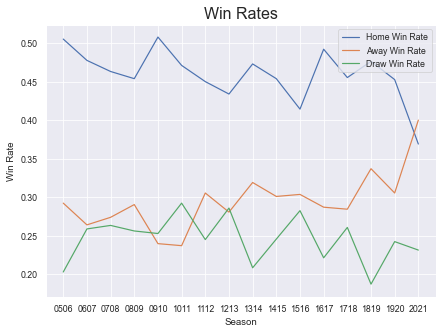

In [32]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)

home_line = sns.lineplot(x=win_rates.index, y=win_rates['homeWin'], ax=ax, label='Home Win Rate')
away_line = sns.lineplot(x=win_rates.index, y=win_rates['awayWin'], ax=ax, label='Away Win Rate')
draw_line = sns.lineplot(x=win_rates.index, y=win_rates['draw'], ax=ax, label='Draw Win Rate')
ax.set_xlabel("Season")
ax.set_ylabel("Win Rate")
plt.title("Win Rates", fontsize=16)
# Add the legend locations
plt.legend(loc='upper right')

**Big change in home win rate this season (20/21)**

Interested to check win rate for each team at home.

In [44]:
team_win_rates = \
(df.groupby(['season', 'HomeTeam'])
    .mean()
    .loc[:, ['homeWin', 'draw', 'awayWin']].reset_index())

**Check the change in Liverpool win rate in 2020/2021.**

Compare homewin rate to other years.

In [45]:
team_win_rates.loc[team_win_rates['HomeTeam']=='Liverpool']

,season,HomeTeam,homeWin,draw,awayWin
9,0506,Liverpool,0.789474,0.157895,0.052632
28,0607,Liverpool,0.736842,0.210526,0.052632
49,0708,Liverpool,0.631579,0.315789,0.052632
68,0809,Liverpool,0.631579,0.368421,0.000000
90,0910,Liverpool,0.684211,0.157895,0.157895
109,1011,Liverpool,0.631579,0.210526,0.157895
127,1112,Liverpool,0.315789,0.473684,0.210526
145,1213,Liverpool,0.473684,0.315789,0.210526
168,1314,Liverpool,0.833333,0.055556,0.111111
188,1415,Liverpool,0.526316,0.263158,0.210526


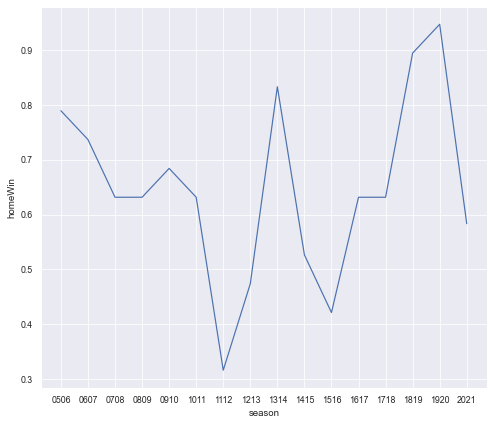

In [48]:
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111)

ax = sns.lineplot(x=team_win_rates['season'], y=team_win_rates['homeWin'].loc[team_win_rates['HomeTeam']=='Liverpool'])
plt.show()

In [59]:
team_win_rates.loc[team_win_rates['HomeTeam']=='Arsenal']

,season,HomeTeam,homeWin,draw,awayWin
0,0506,Arsenal,0.736842,0.157895,0.105263
20,0607,Arsenal,0.631579,0.315789,0.052632
40,0708,Arsenal,0.736842,0.263158,0.000000
60,0809,Arsenal,0.578947,0.263158,0.157895
80,0910,Arsenal,0.789474,0.105263,0.105263
100,1011,Arsenal,0.578947,0.210526,0.210526
120,1112,Arsenal,0.631579,0.210526,0.157895
140,1213,Arsenal,0.578947,0.263158,0.157895
160,1314,Arsenal,0.722222,0.277778,0.000000
180,1415,Arsenal,0.631579,0.263158,0.105263


In [55]:
home_win_rates = \
(df.groupby(['HomeTeam'])
    .homeWin
    .mean())

away_win_rates = \
(df.groupby(['AwayTeam'])
    .awayWin
    .mean())

HomeGameAdv = (home_win_rates - away_win_rates).reset_index().rename(columns={0: 'HomeGameAdv'}).sort_values(by='HomeGameAdv', ascending=False)

In [66]:
home_win_rates.head()

HomeTeam
Arsenal        0.657627
Aston Villa    0.336134
Birmingham     0.342105
Blackburn      0.443609
Blackpool      0.263158
Name: homeWin, dtype: float64

In [60]:
big_clubs = ['Liverpool', 'Man City', 'Man United', 'Chelsea', 'Arsenal', 'Tottenham']
home_win_rates_5 = df[df.HomeTeam.isin(big_clubs)].groupby(['HomeTeam', 'season']).homeWin.mean()
away_win_rates_5 = df[df.AwayTeam.isin(big_clubs)].groupby(['AwayTeam', 'season']).awayWin.mean()

hga_top_5 = home_win_rates_5 - away_win_rates_5

hga_top_5.unstack(level=0)

HomeTeam,Arsenal,Chelsea,Liverpool,Man City,Man United,Tottenham
season,,,,,,
0506,0.421053,0.368421,0.263158,0.263158,0.052632,0.315789
0607,0.263158,0.000000,0.421053,-0.052632,0.105263,0.368421
0708,0.210526,-0.052632,0.157895,0.368421,0.368421,0.263158
0809,0.105263,-0.157895,-0.052632,0.578947,0.210526,0.315789
0910,0.368421,0.368421,0.421053,0.315789,0.263158,0.368421
1011,0.157895,0.368421,0.368421,0.263158,0.684211,0.105263
1112,0.157895,0.315789,-0.105263,0.421053,0.105263,0.315789
1213,0.052632,0.105263,0.105263,0.248538,0.201754,0.052632
1314,0.143275,0.251462,0.307018,0.362573,-0.026316,0.078947


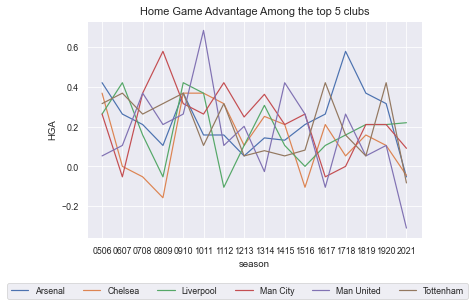

In [65]:
sns.lineplot(x='season', y='HGA', hue='team', data=hga_top_5.reset_index().rename(columns={0: 'HGA', 'HomeTeam': 'team'}))
plt.legend(loc='lower center', ncol=6, bbox_to_anchor=(0.45, -0.3))
plt.title("Home Game Advantage Among the top 5 clubs", fontsize=11)
plt.show()

Examine the change in home win rate for all clubs over the 2020/2021 season. 

In [94]:
team_win_rates.set_index('season', inplace=True)

win_rate_1521 = team_win_rates.loc['1617':'2021']
print(win_rate_1521)

              HomeTeam   homeWin      draw   awayWin
season                                              
1617           Arsenal  0.736842  0.157895  0.105263
1617       Bournemouth  0.473684  0.210526  0.315789
1617           Burnley  0.526316  0.157895  0.315789
1617           Chelsea  0.894737  0.000000  0.105263
1617    Crystal Palace  0.315789  0.105263  0.578947
...                ...       ...       ...       ...
2021       Southampton  0.454545  0.090909  0.454545
2021         Tottenham  0.416667  0.250000  0.333333
2021         West Brom  0.090909  0.272727  0.636364
2021          West Ham  0.454545  0.272727  0.272727
2021            Wolves  0.333333  0.333333  0.333333

[100 rows x 4 columns]


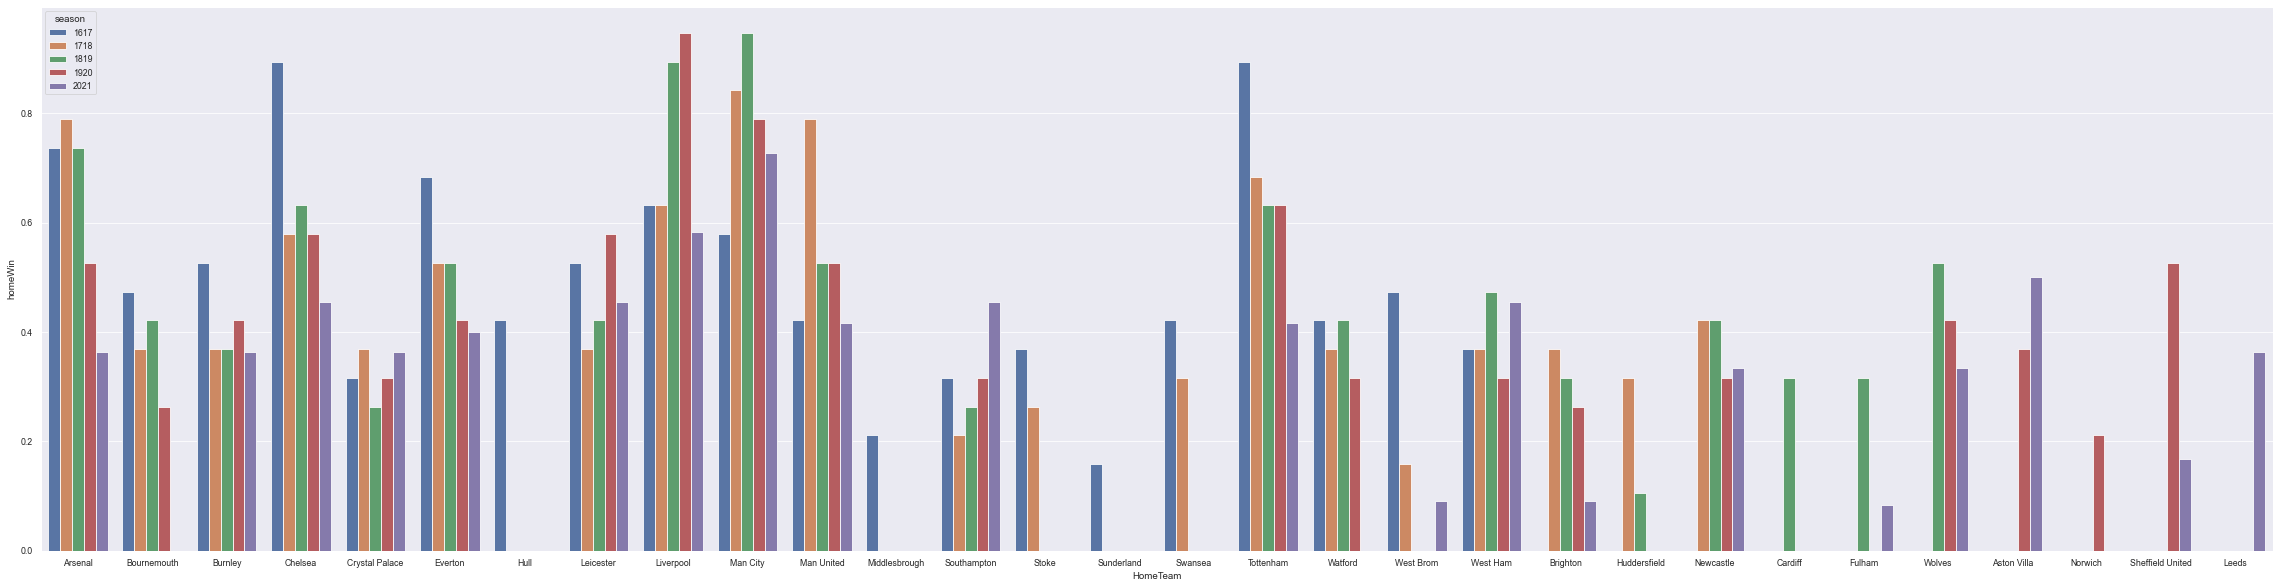

In [96]:
fig, ax = plt.subplots(figsize=(40, 10))
sns.barplot(x=win_rate_1521['HomeTeam'], y=win_rate_1521['homeWin'], hue=win_rate_1521.index, ax=ax)
plt.show()

Full time Home and Away goals

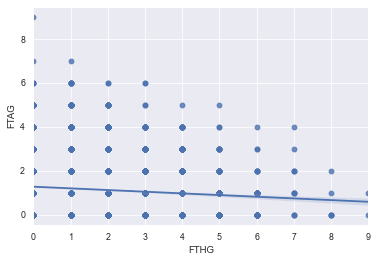

In [101]:
# df.columns

sns.regplot(x='FTHG', y='FTAG', data=df)
plt.show()

**Examine the distribution within each of the numerical features**

The odds columns are likely to be highly skewed, so we may have to account for this later.

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


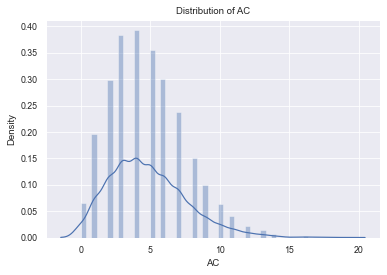

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


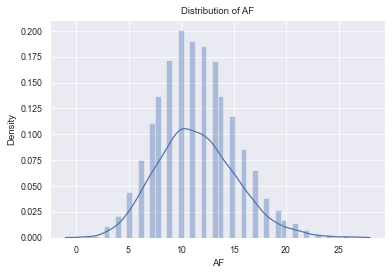

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


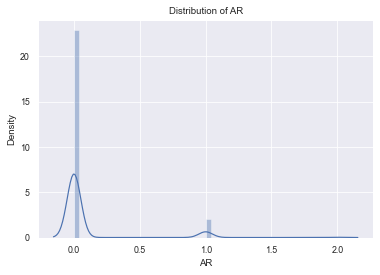

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


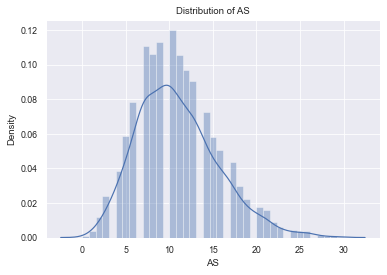

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


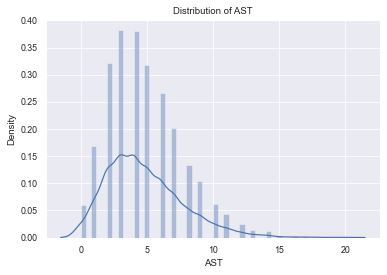

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


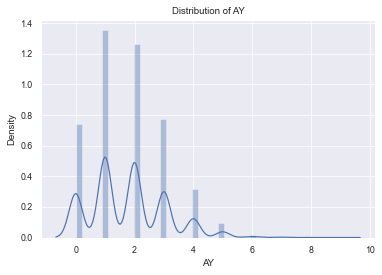

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


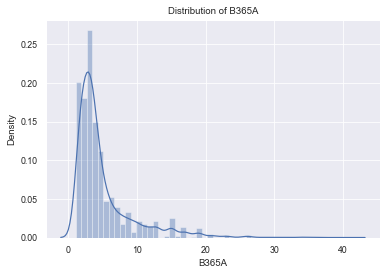

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


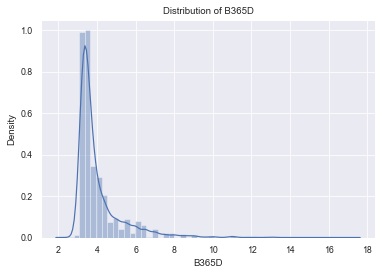

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


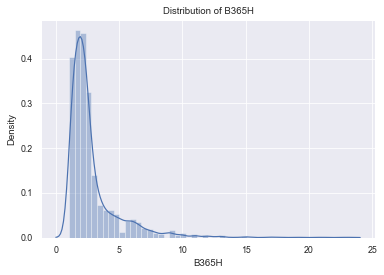

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


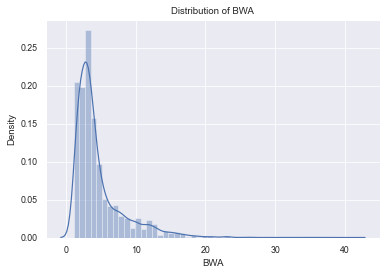

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


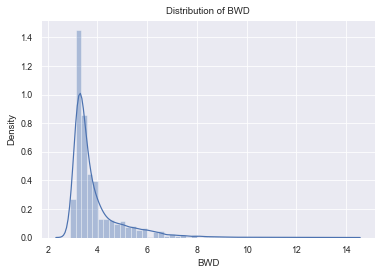

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


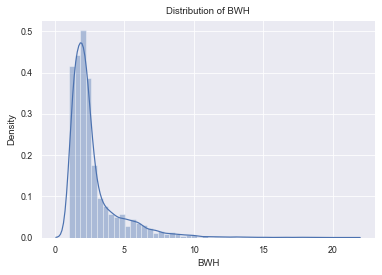

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


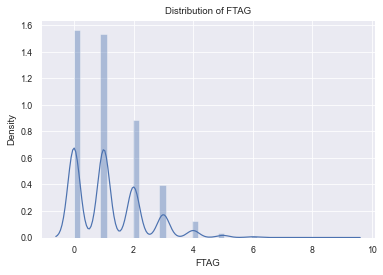

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


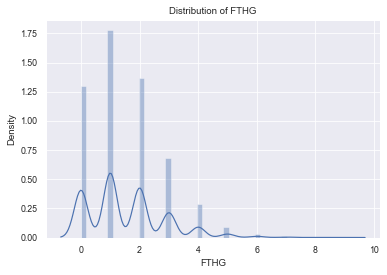

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


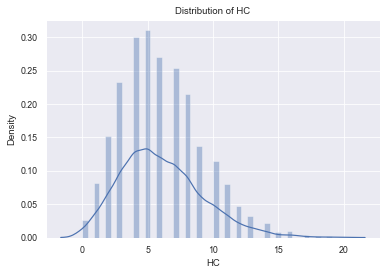

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


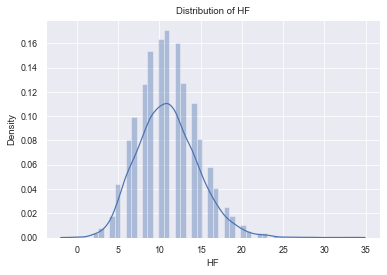

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


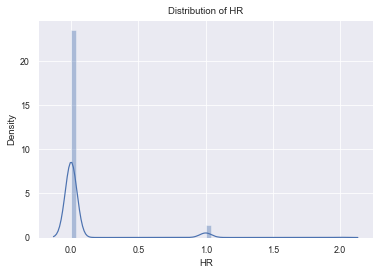

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


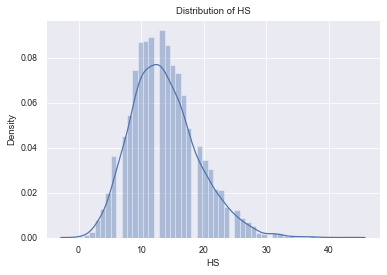

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


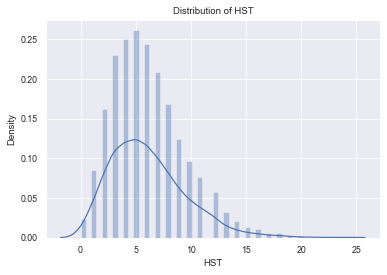

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


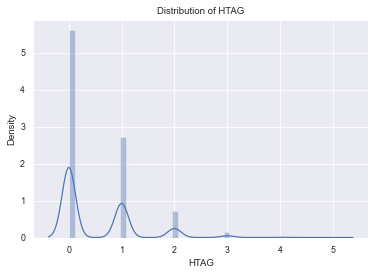

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


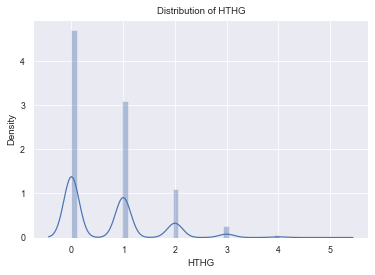

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


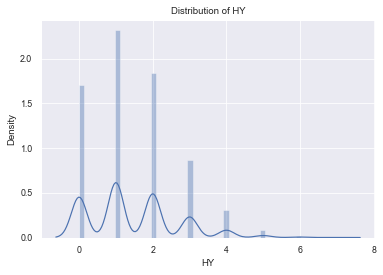

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


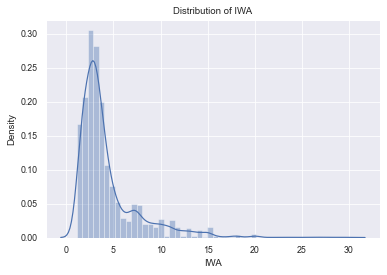

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


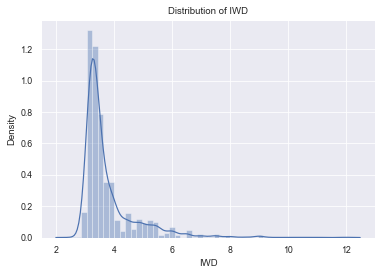

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


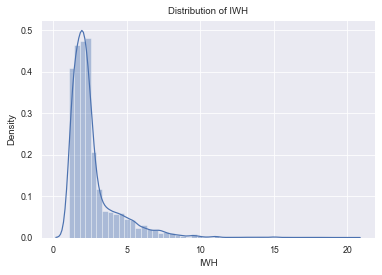

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


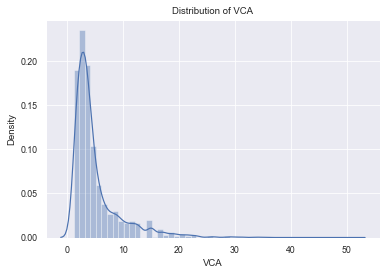

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


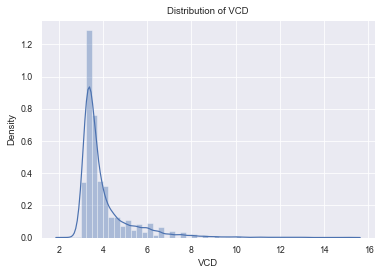

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


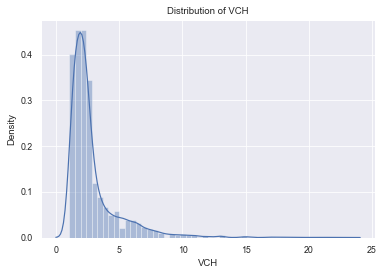

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


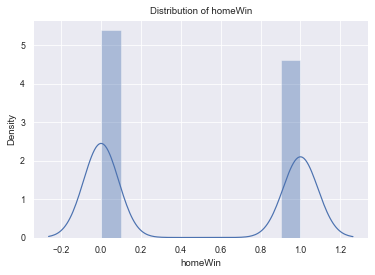

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


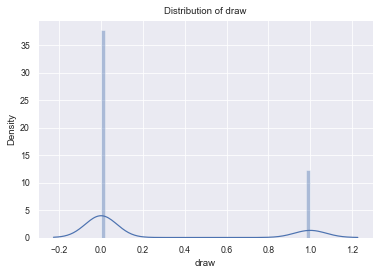

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


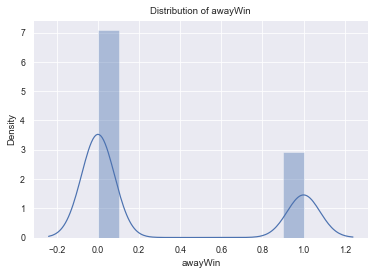

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


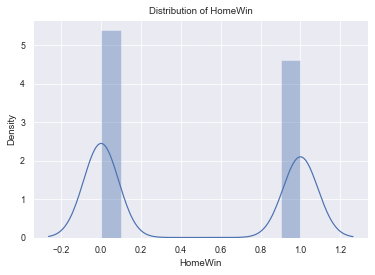

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


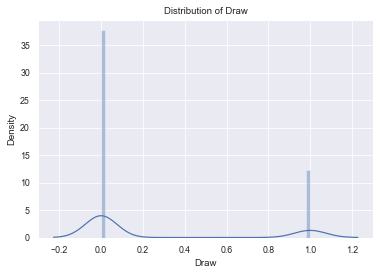

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


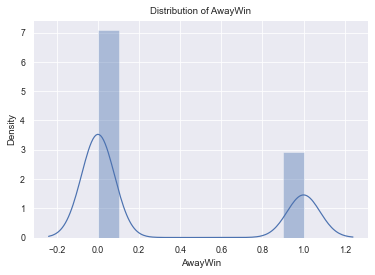

In [98]:
for col in df.select_dtypes(include='number').columns:
    sns.distplot(df[col])
    plt.title(f"Distribution of {col}")
    plt.show()

**Home Ground Bias and referees**

In [104]:
# The top 20 referees over the last 15 years based on games played.
refs = df['Referee'].value_counts().head(20).index
print(refs)

Index(['M Dean', 'M Atkinson', 'A Marriner', 'L Mason', 'M Oliver',
       'M Clattenburg', 'A Taylor', 'H Webb', 'P Dowd', 'K Friend', 'J Moss',
       'C Foy', 'M Jones', 'L Probert', 'C Pawson', 'M Halsey', 'P Walton',
       'A Wiley', 'S Bennett', 'N Swarbrick'],
      dtype='object')


In [108]:
# The relationshop between referee and the homeWin %
df[df['Referee'].isin(refs)].groupby('Referee')['homeWin'].mean().sort_values(ascending=False)

Referee
L Mason          0.503521
C Foy            0.500000
L Probert        0.483516
M Clattenburg    0.480000
M Jones          0.475248
A Wiley          0.472222
P Dowd           0.469880
A Taylor         0.463235
K Friend         0.460581
H Webb           0.456604
C Pawson         0.452941
M Atkinson       0.451306
S Bennett        0.446043
M Dean           0.445455
J Moss           0.443038
M Oliver         0.436170
A Marriner       0.436047
M Halsey         0.433962
P Walton         0.425676
N Swarbrick      0.419847
Name: homeWin, dtype: float64

Martin Atkinson has never refereed a game where the away team win. 

In [112]:
df['GoalDiff'] = df['FTHG'] - df['FTAG']

stat_cols = ['AC', 'AF', 'AR', 'AS', 'AST', 'AY', 'HC', 'HF', 'HR', 'HS', 'HST', 'HTR', 'HY', 'GoalDiff']

stat_correlations = df[stat_cols].corr()
stat_correlations['GoalDiff'].sort_values()

AST        -0.358041
AS         -0.308480
HY         -0.149442
HR         -0.126410
AC         -0.077961
HF         -0.058703
AF          0.000075
AY          0.010601
HC          0.078145
AR          0.103408
HS          0.286560
HST         0.384153
GoalDiff    1.000000
Name: GoalDiff, dtype: float64

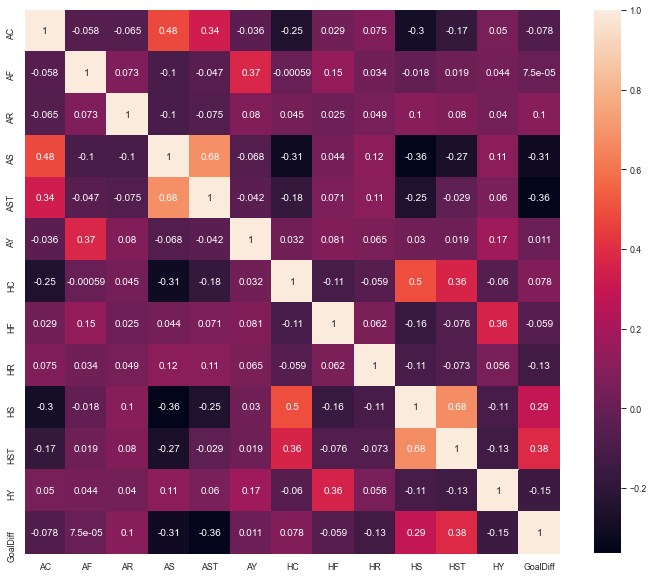

In [117]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)

sns.heatmap(stat_correlations, annot=True, annot_kws={'size': 10}, ax=ax)

# Data Preparation & Feature Engineering

Typical issue faced by aspect of modelling sport is the issue of Machine Learning algorithms requiring all features for the teams playing to be on the same row of a table, whereas when we actual calculate these features, we usually require the teams to be on separate rows as it makes it a lot easier to calculate typical features, such as expontentially weighted moving averages.

In [129]:
# Export df to csv
df.to_csv("data/epl_data.csv", index=False)

In [143]:
df.reset_index()
df.head(3)

,AC,AF,AR,AS,AST,AY,AwayTeam,B365A,B365D,B365H,BWA,BWD,BWH,Date,Day,Div,FTAG,FTHG,FTR,HC,HF,HR,HS,HST,HTAG,HTHG,HTR,HY,HomeTeam,IWA,IWD,IWH,Month,Referee,VCA,VCD,VCH,Year,season,homeWin,draw,awayWin,HomeWin,Draw,AwayWin,margin,GoalDiff
7,6.0,14.0,1.0,11.0,5.0,1.0,Blackburn,2.75,3.20,2.5,2.90,3.30,2.20,2005-08-13,13,E0,1.0,3.0,H,2.0,11.0,0.0,13.0,5.0,1.0,0.0,A,0.0,West Ham,2.7,3.0,2.3,08,A Wiley,2.75,3.25,2.4,05,0506,1,0,0,1,0,0,2.0,2.0
0,8.0,16.0,0.0,13.0,6.0,2.0,Bolton,3.00,3.25,2.3,3.15,3.25,2.10,2005-08-13,13,E0,2.0,2.0,D,7.0,14.0,0.0,3.0,2.0,2.0,2.0,D,0.0,Aston Villa,3.1,3.0,2.1,08,M Riley,3.10,3.25,2.2,05,0506,0,1,0,0,1,0,0.0,0.0
1,6.0,14.0,0.0,12.0,5.0,1.0,Man United,1.72,3.40,5.0,1.75,3.35,4.35,2005-08-13,13,E0,2.0,0.0,A,8.0,15.0,0.0,10.0,5.0,1.0,0.0,A,3.0,Everton,1.8,3.1,3.8,08,G Poll,1.80,3.30,4.5,05,0506,0,0,1,0,0,1,-2.0,-2.0


In [134]:
df.columns

Index(['AC', 'AF', 'AR', 'AS', 'AST', 'AY', 'AwayTeam', 'B365A', 'B365D',
       'B365H', 'BWA', 'BWD', 'BWH', 'Date', 'Day', 'Div', 'FTAG', 'FTHG',
       'FTR', 'HC', 'HF', 'HR', 'HS', 'HST', 'HTAG', 'HTHG', 'HTR', 'HY',
       'HomeTeam', 'IWA', 'IWD', 'IWH', 'Month', 'Referee', 'VCA', 'VCD',
       'VCH', 'Year', 'season', 'homeWin', 'draw', 'awayWin', 'HomeWin',
       'Draw', 'AwayWin', 'margin', 'GoalDiff'],
      dtype='object')

In [132]:
stats = df[[
    'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'HTHG', 'HTAG',
    'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR',
    'AR'
    ]]

stats.head(5)

,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
7,West Ham,Blackburn,3.0,1.0,0.0,1.0,13.0,11.0,5.0,5.0,11.0,14.0,2.0,6.0,0.0,1.0,0.0,1.0
0,Aston Villa,Bolton,2.0,2.0,2.0,2.0,3.0,13.0,2.0,6.0,14.0,16.0,7.0,8.0,0.0,2.0,0.0,0.0
1,Everton,Man United,0.0,2.0,0.0,1.0,10.0,12.0,5.0,5.0,15.0,14.0,8.0,6.0,3.0,1.0,0.0,0.0
2,Fulham,Birmingham,0.0,0.0,0.0,0.0,15.0,7.0,7.0,4.0,12.0,13.0,6.0,6.0,1.0,2.0,0.0,0.0
3,Man City,West Brom,0.0,0.0,0.0,0.0,15.0,13.0,8.0,3.0,13.0,11.0,3.0,6.0,2.0,3.0,0.0,0.0


In [138]:
betting = df[[
    'B365A', 'B365D', 'B365H', 'BWA', 'BWD', 'BWH', 'Day', 'Div', 'IWA', 'IWD', 'IWH', 'Month', 
    'VCA', 'VCD', 'VCH', 'Year', 'homeWin', 'awayWin', 'HomeTeam', 'AwayTeam'
]]

In [147]:
# Define a function which restructures our DataFrame
def create_multiline_df_stats(old_stats_df):
    # Create a list of columns we want and their mappings to more interpretable names
    home_stats_cols = ['HomeTeam', 'FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY',
                       'HR', 'AR']

    away_stats_cols = ['AwayTeam', 'FTAG', 'FTHG', 'HTAG', 'HTHG', 'AS', 'HS', 'AST', 'HST', 'AF', 'HF', 'AC', 'HC', 'AY', 'HY',
                       'AR', 'HR']

    stats_cols_mapping = ['team', 'goalsFor', 'goalsAgainst', 'halfTimeGoalsFor', 'halfTimeGoalsAgainst', 'shotsFor',
                          'shotsAgainst', 'shotsOnTargetFor', 'shotsOnTargetAgainst', 'freesFor', 'freesAgainst', 
                          'cornersFor', 'cornersAgainst', 'yellowsFor', 'yellowsAgainst', 'redsFor', 'redsAgainst']

    # Create a dictionary of the old column names to new column names
    home_mapping = {old_col: new_col for old_col, new_col in zip(home_stats_cols, stats_cols_mapping)}
    away_mapping = {old_col: new_col for old_col, new_col in zip(away_stats_cols, stats_cols_mapping)}

    # Put each team onto an individual row
    multi_line_stats = (old_stats_df.index + home_stats_cols] # Filter for only the home team columns
                    .rename(columns=home_mapping) # Rename the columns
                    .assign(homeGame=1) # Assign homeGame=1 so that we can use a general function later
                    .append((old_stats_df[['gameId'] + away_stats_cols]) # Append the away team columns
                            .rename(columns=away_mapping) # Rename the away team columns
                            .assign(homeGame=0), sort=True)
                    .sort_values(by='gameId') # Sort the values
                    .reset_index(drop=True))
    return multi_line_stats

In [146]:
df.isnull().sum()

AC          0
AF          0
AR          0
AS          0
AST         0
AY          0
AwayTeam    0
B365A       0
B365D       0
B365H       0
BWA         0
BWD         0
BWH         0
Date        0
Day         0
Div         0
FTAG        0
FTHG        0
FTR         0
HC          0
HF          0
HR          0
HS          0
HST         0
HTAG        0
HTHG        0
HTR         0
HY          0
HomeTeam    0
IWA         0
IWD         0
IWH         0
Month       0
Referee     0
VCA         0
VCD         0
VCH         0
Year        0
season      0
homeWin     0
draw        0
awayWin     0
HomeWin     0
Draw        0
AwayWin     0
margin      0
GoalDiff    0
dtype: int64